# Ridge regression (gradient descent)

### Fire up graphlab create

In [1]:
import graphlab

### Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [91]:
sales = graphlab.SFrame('kc_house_data.gl/')

### Function to convert SFrame to Numpy data

In [92]:
import numpy as np

In [93]:
def get_numpy_data(data_sframe, features, output):
    
    data_sframe['constant'] = 1 # new constant column in the sframe signifying intercept
    
    features = ['constant'] + features # prepend constant to features list
    
    features_sframe = data_sframe[features] # new sframe selecting columns from data_sframe mentioned in features list

    feature_matrix = features_sframe.to_numpy() # convert sframe to numpy matrix

    output_sarray = data_sframe[output] # an sarray consisting of the output column

    output_array = output_sarray.to_numpy() # converts sarray to a numpy array

    return(feature_matrix, output_array)

### Function to predict output given feature matrix and weight vector

In [94]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

### Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. The cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) and add the derivative of the regularization part. The derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We dont have to regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

The following derivative function computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).

### Function to compute derivative of weight

In [95]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    derivative = 0
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant:
        total_error = errors.sum()
        derivative = 2 * total_error
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        dot_product = np.dot(errors, feature)
        rss_part = 2 * dot_product
        regularized_part = 2 * l2_penalty * weight
        derivative = rss_part + regularized_part
    return derivative

### Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. 

We will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default.

### Gradient descent algorithm with Ridge regression

In [96]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) # a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    # while not reached maximum number of iterations        
    while iteration < max_iterations: 
        iteration += 1  # increment iteration counter
        
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)

        # compute the errors in prediction
        errors = predictions - output

        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))
        
        for i in xrange(len(weights)): # loop over each weight
            
            # feature column associated with weights[i]
            feature_column = feature_matrix[:,i]
            
            # computing derivative of weight[i]
            if i == 0:  # feature is constant
                derivative = feature_derivative_ridge(errors, feature_column, weights[i], l2_penalty, True)
            else:       # feature is not constant
                derivative = feature_derivative_ridge(errors, feature_column, weights[i], l2_penalty, False)
                
            # subtracting the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights

### Visualizing effect of L2 penalty

### Simple model with no L2 penalty (No regularization)

In [97]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [98]:
train_data,test_data = sales.random_split(.8,seed=0)

Get numpy versions by using `get_numpy_data` of your data with only this feature, for both the `train_data` and the `test_data`. 

In [99]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [100]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

#### Learned weights with no regulariztion

In [101]:
l2_penalty = 0.0
simple_weight_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 
                                                            l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  5.39426721314e+15
Iteration = 3
Cost function =  4.0232377365e+15
Iteration = 4
Cost function =  3.10125618392e+15
Iteration = 5
Cost function =  2.48124764451e+15
Iteration = 6
Cost function =  2.06430807789e+15
Iteration = 7
Cost function =  1.78392709737e+15
Iteration = 8
Cost function =  1.59537820315e+15
Iteration = 9
Cost function =  1.46858399105e+15
Iteration = 10
Cost function =  1.38331819148e+15
Iteration = 20
Cost function =  1.2115621405e+15
Iteration = 30
Cost function =  1.20831376268e+15
Iteration = 40
Cost function =  1.20825232625e+15
Iteration = 50
Cost function =  1.20825116361e+15
Iteration = 60
Cost function =  1.20825114092e+15
Iteration = 70
Cost function =  1.20825113978e+15
Iteration = 80
Cost function =  1.20825113905e+15
Iteration = 90
Cost function =  1.20825113832e+15
Iteration = 100
Cost function =  1.2082511376e+15
Iteration = 2

#### Learned weights with regulariztion

In [102]:
l2_penalty = 1e11
simple_weight_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 
                                                            l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  5.61830389841e+15
Iteration = 3
Cost function =  4.92061327812e+15
Iteration = 4
Cost function =  4.65238194261e+15
Iteration = 5
Cost function =  4.54925876401e+15
Iteration = 6
Cost function =  4.50961239088e+15
Iteration = 7
Cost function =  4.49437005028e+15
Iteration = 8
Cost function =  4.48850998403e+15
Iteration = 9
Cost function =  4.48625698853e+15
Iteration = 10
Cost function =  4.48539075267e+15
Iteration = 20
Cost function =  4.48484886803e+15
Iteration = 30
Cost function =  4.48484788048e+15
Iteration = 40
Cost function =  4.48484693108e+15
Iteration = 50
Cost function =  4.48484598169e+15
Iteration = 60
Cost function =  4.48484503229e+15
Iteration = 70
Cost function =  4.4848440829e+15
Iteration = 80
Cost function =  4.48484313351e+15
Iteration = 90
Cost function =  4.48484218411e+15
Iteration = 100
Cost function =  4.48484123472e+15
Iteration

### Plotting the two learned models
The blue line is for the model with no regularization and the red line is for the one with high regularization.

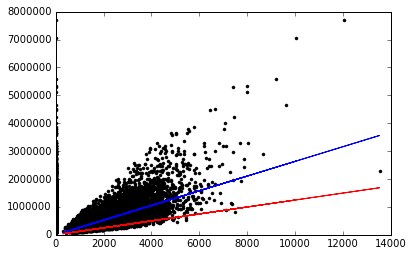

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weight_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weight_high_penalty),'r-')

### RSS function

In [104]:
def RSS (predicted_output, true_output):
    residuals = predicted_output - true_output
    residuals_squared = residuals * residuals
    residuals_sum_of_squares = residuals_squared.sum()
    return residuals_sum_of_squares

### RSS on the TEST data: (Simple model)
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

In [105]:
predictions = predict_output(simple_test_feature_matrix, initial_weights)
print "For simple model and initial weights:" 
print "Weight (Coefficients): " + str(initial_weights)
print "RSS: " + str(RSS(predictions, test_output))

For simple model and initial weights:
Weight (Coefficients): [ 0.  0.]
RSS: 1.78427328252e+15


In [106]:
predictions = predict_output(simple_test_feature_matrix, simple_weight_0_penalty)
print "For simple model and weights with no regularization:"
print "Weight (Coefficient): " + str(simple_weight_0_penalty)
print "RSS: " + str(RSS(predictions, test_output))

For simple model and weights with no regularization:
Weight (Coefficient): [ -1.63113501e-01   2.63024369e+02]
RSS: 2.75723634598e+14


In [107]:
predictions = predict_output(simple_test_feature_matrix, simple_weight_high_penalty)
print "For simple model and weights with regularization:"
print "Weight (Coefficient): " + str(simple_weight_high_penalty)
print "RSS: " + str(RSS(predictions, test_output))

For simple model and weights with regularization:
Weight (Coefficient): [   9.76730383  124.57217565]
RSS: 6.94642100914e+14


### Which weights perform the best?
#### The weights with no regularization seem to perform the best for now!

### Multiple regression with L2 penalty (Regularization)

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [108]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [109]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

#### Learned weights with no regulariztion

In [110]:
l2_penalty = 0.0
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 
                                                               l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  4.0567523315e+15
Iteration = 3
Cost function =  2.52956511433e+15
Iteration = 4
Cost function =  1.83855669428e+15
Iteration = 5
Cost function =  1.52567557521e+15
Iteration = 6
Cost function =  1.38378949867e+15
Iteration = 7
Cost function =  1.31923260628e+15
Iteration = 8
Cost function =  1.28964887203e+15
Iteration = 9
Cost function =  1.27588472408e+15
Iteration = 10
Cost function =  1.26927880758e+15
Iteration = 20
Cost function =  1.25781238632e+15
Iteration = 30
Cost function =  1.25195457127e+15
Iteration = 40
Cost function =  1.24675542316e+15
Iteration = 50
Cost function =  1.24213950875e+15
Iteration = 60
Cost function =  1.23804140114e+15
Iteration = 70
Cost function =  1.23440301346e+15
Iteration = 80
Cost function =  1.23117277498e+15
Iteration = 90
Cost function =  1.22830490006e+15
Iteration = 100
Cost function =  1.22575873926e+15
Iteration =

#### Learned weights with regulariztion

In [111]:
l2_penalty = 1e11
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 
                                                               l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7.43305185103e+15
Iteration = 2
Cost function =  4.46048979029e+15
Iteration = 3
Cost function =  3.79667446884e+15
Iteration = 4
Cost function =  3.64831953044e+15
Iteration = 5
Cost function =  3.61509110322e+15
Iteration = 6
Cost function =  3.60760274251e+15
Iteration = 7
Cost function =  3.60588632216e+15
Iteration = 8
Cost function =  3.60547487453e+15
Iteration = 9
Cost function =  3.60536516777e+15
Iteration = 10
Cost function =  3.60532940218e+15
Iteration = 20
Cost function =  3.60529428102e+15
Iteration = 30
Cost function =  3.60529353727e+15
Iteration = 40
Cost function =  3.60529308275e+15
Iteration = 50
Cost function =  3.60529263111e+15
Iteration = 60
Cost function =  3.60529217949e+15
Iteration = 70
Cost function =  3.60529172788e+15
Iteration = 80
Cost function =  3.60529127626e+15
Iteration = 90
Cost function =  3.60529082465e+15
Iteration = 100
Cost function =  3.60529037303e+15
Iteratio

### RSS on the TEST data: (Multiple model)
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

In [112]:
predictions = predict_output(test_feature_matrix, initial_weights)
print "For multiple model and initial weights:" 
print "Weight (Coefficients): " + str(initial_weights)
print "RSS: " + str(RSS(predictions, test_output))

For multiple model and initial weights:
Weight (Coefficients): [ 0.  0.  0.]
RSS: 1.78427328252e+15


In [113]:
predictions = predict_output(test_feature_matrix, multiple_weights_0_penalty)
print "For multiple model and weights with no regularization:" 
print "Weight (Coefficients): " + str(multiple_weights_0_penalty)
print "RSS: " + str(RSS(predictions, test_output))

For multiple model and weights with no regularization:
Weight (Coefficients): [  -0.35743482  243.0541689    22.41481594]
RSS: 2.74067618287e+14


In [114]:
predictions = predict_output(test_feature_matrix, multiple_weights_high_penalty)
print "For multiple model and weights with regularization:" 
print "Weight (Coefficients): " + str(multiple_weights_high_penalty)
print "RSS: " + str(RSS(predictions, test_output))

For multiple model and weights with regularization:
Weight (Coefficients): [  6.7429658   91.48927361  78.43658768]
RSS: 5.0040480058e+14


### Which weights perform best?

#### The weights with no regularization seem to perform the best in the multiple model too same as the simple model result!

## House 1 price prediction from test dataset

In [118]:
#House no.1 in the test dataset
test_feature_matrix[0]

array([  1.00000000e+00,   1.43000000e+03,   1.78000000e+03])

In [77]:
#Features in consideration
model_features

['sqft_living', 'sqft_living15']

In [80]:
#Output feature to predict
my_output

'price'

In [119]:
#Weights with no regularization learned
multiple_weights_0_penalty

array([  -0.35743482,  243.0541689 ,   22.41481594])

In [120]:
#Weights with regularization learned
multiple_weights_high_penalty

array([  6.7429658 ,  91.48927361,  78.43658768])

In [122]:
#Predicting the output using weights with no regularization
predicted_output = predict_output(test_feature_matrix[0:1], multiple_weights_0_penalty)
print "The predicted house 1 price (weights with no regularization): "
predicted_output[0]

The predicted house 1 price (weights with no regularization): 


387465.47646474396

In [123]:
#Predicting the output using weights with regularization
predicted_output = predict_output(test_feature_matrix[0:1], multiple_weights_high_penalty)
print "The predicted house 1 price (weights with regularization): "
predicted_output[0]

The predicted house 1 price (weights with regularization): 


270453.53030485858

In [125]:
#Actual house 1 price
print "The actual house 1 price is: "
test_output[0]

The actual house 1 price is: 


310000.0